In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sequence-recognition-using-rnn-lstm-gru/sample_submission.csv
/kaggle/input/sequence-recognition-using-rnn-lstm-gru/train.json
/kaggle/input/sequence-recognition-using-rnn-lstm-gru/test.json
/kaggle/input/sequence-recognition-using-rnn-lstm-gru/vocabulary.json



Training LSTM...
Epoch 1: Loss=0.9876, Val Acc=0.8575
Epoch 2: Loss=0.3266, Val Acc=0.9337
Epoch 3: Loss=0.1535, Val Acc=0.9900
Epoch 4: Loss=0.0409, Val Acc=0.9962
Epoch 5: Loss=0.0363, Val Acc=0.9950
Epoch 6: Loss=0.0309, Val Acc=0.9900
Epoch 7: Loss=0.0157, Val Acc=0.9975
Epoch 8: Loss=0.0892, Val Acc=0.9537
Epoch 9: Loss=0.0532, Val Acc=0.9775
Epoch 10: Loss=0.0800, Val Acc=0.9862

Training GRU...
Epoch 1: Loss=1.0502, Val Acc=0.8063
Epoch 2: Loss=0.2082, Val Acc=0.9925
Epoch 3: Loss=0.0288, Val Acc=0.9962
Epoch 4: Loss=0.0077, Val Acc=0.9975
Epoch 5: Loss=0.0064, Val Acc=0.9988
Epoch 6: Loss=0.0040, Val Acc=0.9975
Epoch 7: Loss=0.0036, Val Acc=0.9975
Epoch 8: Loss=0.0049, Val Acc=0.9962
Epoch 9: Loss=0.0161, Val Acc=0.9988
Epoch 10: Loss=0.0045, Val Acc=0.9975


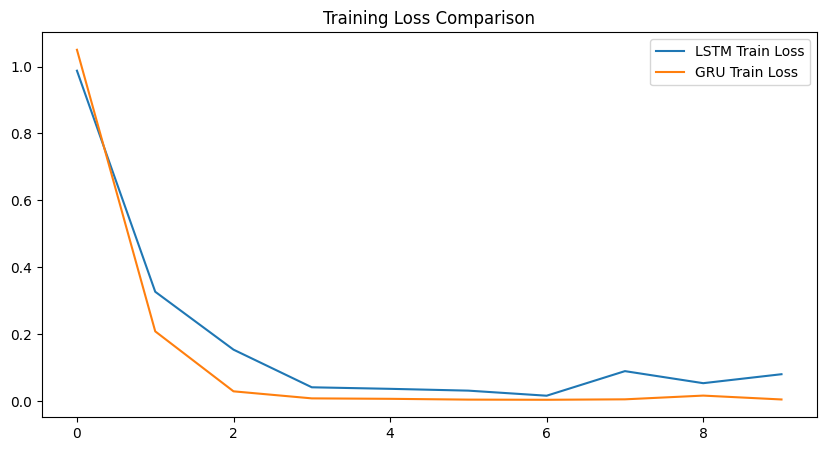

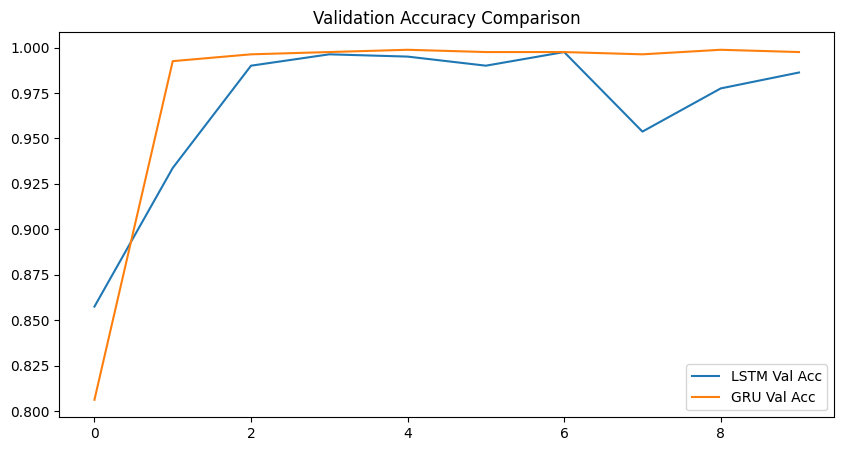

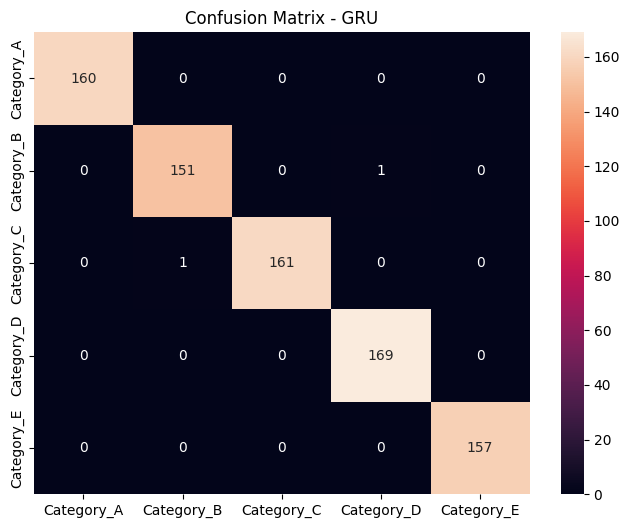

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Hyperparameters and Data Preparation ---
MAX_LEN = 128      # Maximum length of sequences to prevent memory issues
BATCH_SIZE = 64    # Number of samples processed before updating the model
EMBED_DIM = 128    # Dimension of the vector space for token embeddings
HIDDEN_DIM = 128   # Number of features in the hidden state of LSTM/GRU
EPOCHS = 10        # Number of times to iterate over the entire dataset
LR = 1e-3          # Learning rate for the optimizer
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available

# Load datasets from JSON files
base_path = '/kaggle/input/sequence-recognition-using-rnn-lstm-gru/'
train_full_df = pd.read_json(f'{base_path}train.json')
test_df = pd.read_json(f'{base_path}test.json')

# Convert string labels (Category_A, etc.) into integer indices (0, 1, 2...)
le = LabelEncoder()
train_full_df['label_idx'] = le.fit_transform(train_full_df['labels'])
num_classes = len(le.classes_)
vocab_size = 10000 + 1 # Include +1 for the padding token (usually 0)

# Split data: 80% for training and 20% for validation to check for overfitting
train_df, val_df = train_test_split(train_full_df, test_size=0.2, random_state=42)

# Custom Dataset class to handle sequence data
class SeqDataset(Dataset):
    def __init__(self, sequences, labels=None):
        # Trim sequences to MAX_LEN and convert to PyTorch Tensors
        self.sequences = [torch.tensor(s[:MAX_LEN]) for s in sequences]
        self.labels = labels

    def __len__(self): 
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.labels is not None: 
            return self.sequences[idx], self.labels[idx]
        return self.sequences[idx]

# Function to dynamically pad sequences to the same length within each batch
def collate_fn(batch):
    if isinstance(batch[0], tuple): # Training mode: returns (data, label)
        seqs, labels = zip(*batch)
        # Pad with 0s so all sequences in the batch have the same length
        return pad_sequence(seqs, batch_first=True, padding_value=0), torch.tensor(labels)
    # Test mode: returns data only
    return pad_sequence(batch, batch_first=True, padding_value=0)

# Create DataLoaders to handle batching and shuffling
train_loader = DataLoader(
    SeqDataset(train_df['sequences'].tolist(), train_df['label_idx'].tolist()), 
    batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

val_loader = DataLoader(
    SeqDataset(val_df['sequences'].tolist(), val_df['label_idx'].tolist()), 
    batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

# --- 2. Model Definitions (LSTM and GRU) ---

# Bidirectional LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Embedding layer converts integer IDs to dense vectors
        self.embedding = nn.Embedding(vocab_size, EMBED_DIM, padding_idx=0)
        # Bidirectional LSTM processes the sequence forward and backward
        self.lstm = nn.LSTM(EMBED_DIM, HIDDEN_DIM, batch_first=True, bidirectional=True)
        # Final fully connected layer (HIDDEN_DIM * 2 because it's bidirectional)
        self.fc = nn.Linear(HIDDEN_DIM * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        # Get hidden state from the last time step of both directions
        _, (hn, _) = self.lstm(x)
        # Concatenate the final forward and backward hidden states
        return self.fc(torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1))

# Bidirectional GRU Model (Slightly more efficient than LSTM)
class GRUClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBED_DIM, padding_idx=0)
        self.gru = nn.GRU(EMBED_DIM, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(HIDDEN_DIM * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hn = self.gru(x)
        # Concatenate the final forward and backward hidden states
        return self.fc(torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1))

# --- 3. Training and Evaluation Functions ---

def train_model(model_class, name):
    print(f"\nTraining {name}...")
    model = model_class().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR) # AdamW is better for weight decay
    criterion = nn.CrossEntropyLoss()                 # Standard loss for multi-class classification
    
    history = {'train_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()      # Clear previous gradients
            loss = criterion(model(x), y)
            loss.backward()            # Backpropagation
            optimizer.step()           # Update weights
            total_loss += loss.item()
        
        # Validation Phase
        model.eval()
        correct, total = 0, 0
        with torch.no_grad(): # Disable gradient calculation for faster inference
            for x, y in val_loader:
                outputs = model(x.to(DEVICE))
                _, preds = torch.max(outputs, 1)
                correct += (preds.cpu() == y).sum().item()
                total += y.size(0)
        
        acc = correct / total
        history['train_loss'].append(total_loss/len(train_loader))
        history['val_acc'].append(acc)
        print(f"Epoch {epoch+1}: Loss={history['train_loss'][-1]:.4f}, Val Acc={acc:.4f}")
        
    return model, history

# Run the training for both architectures to compare them
lstm_model, lstm_hist = train_model(LSTMClassifier, "LSTM")
gru_model, gru_hist = train_model(GRUClassifier, "GRU")

# --- 4. Visualization ---

# (1) Plot Training Loss comparison
plt.figure(figsize=(10, 5))
plt.plot(lstm_hist['train_loss'], label='LSTM Train Loss')
plt.plot(gru_hist['train_loss'], label='GRU Train Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.savefig('loss_comparison.png')
plt.show()

# (2) Plot Validation Accuracy comparison
plt.figure(figsize=(10, 5))
plt.plot(lstm_hist['val_acc'], label='LSTM Val Acc')
plt.plot(gru_hist['val_acc'], label='GRU Val Acc')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.savefig('accuracy_comparison.png')
plt.show()

# (3) Plot Confusion Matrix for the better-performing model (GRU)
def plot_cm(model, name):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in val_loader:
            _, preds = torch.max(model(x.to(DEVICE)), 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.numpy())
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'cm_{name}.png')
    plt.show()

plot_cm(gru_model, "GRU")

# --- 5. Generate Submission File (Using the Best Model) ---
test_loader = DataLoader(SeqDataset(test_df['sequences']), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
gru_model.eval()
predictions = []

with torch.no_grad():
    for x in test_loader:
        _, preds = torch.max(gru_model(x.to(DEVICE)), 1)
        predictions.extend(preds.cpu().numpy())

# Map integer predictions back to string labels and save to CSV
submission = pd.DataFrame({'id': test_df.index, 'labels': le.inverse_transform(predictions)})
submission.to_csv('submission.csv', index=False)